# **Anomaly Detection in MNIST Images**

Here I use three different models to find anomalous digits.



##**Autoencoder**


In this project, we implemented an anomaly detection system using autoencoders on the MNIST dataset, which consists of grayscale images of handwritten digits from 0 to 9. The goal is to detect anomalous digits (digits 7 to 9) from normal digits (digits 0 to 4) using an unsupervised learning approach.

In [4]:
#Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from sklearn.neighbors import LocalOutlierFactor
from sklearn.datasets import fetch_openml
from sklearn.ensemble import IsolationForest


In [5]:
# Load the MNIST dataset. Here I will be using MNIST datasets since this size of dataset can be handled by my personal devices.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [6]:
# Flatten the images and normalize pixel values to [0, 1]
X_train = X_train.reshape(-1, 28 * 28).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28 * 28).astype('float32') / 255.0

In [7]:
anomaly_digits = [7, 8, 9]
y_anomaly = np.array([1 if digit in anomaly_digits else 0 for digit in y_test])

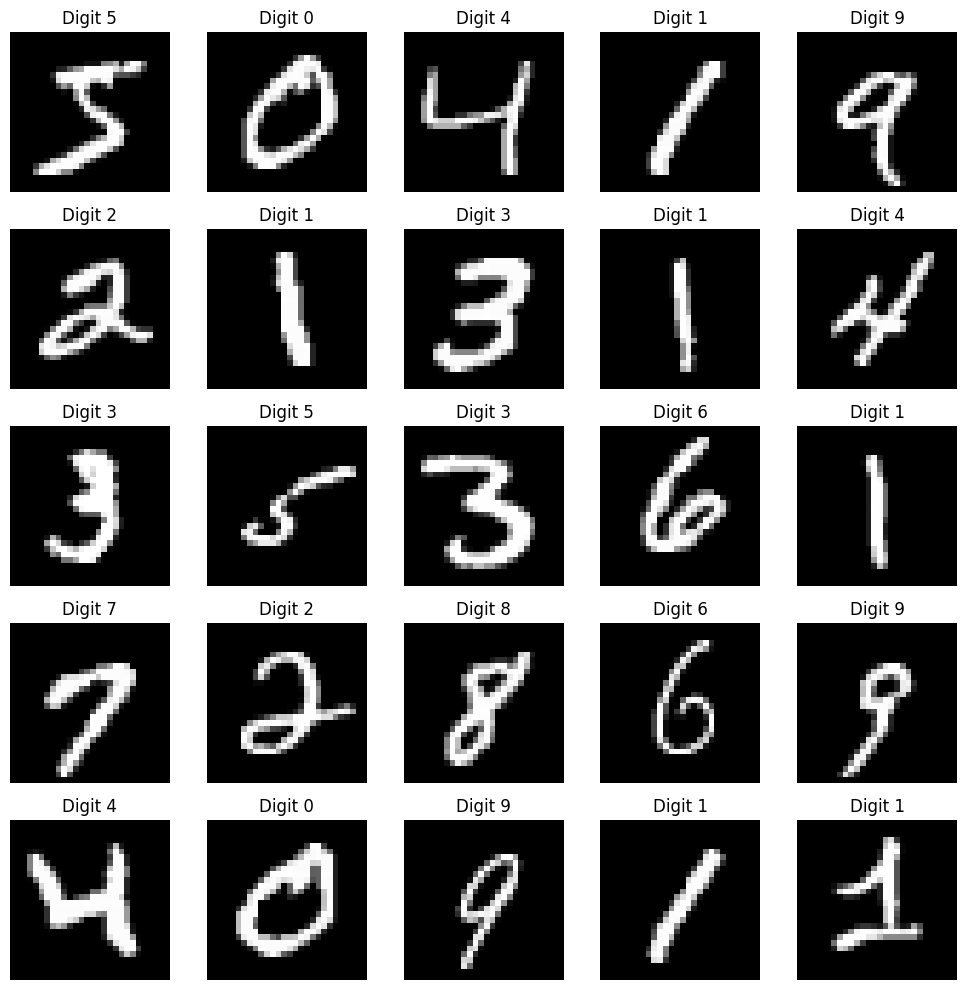

In [13]:
# Display the first 25 images from the training dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Digit {y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

An autoencoder is an unsupervised artificial neural network used for dimensionality reduction and feature learning. It consists of an encoder that compresses the input data into a lower-dimensional representation (latent space) and a decoder that reconstructs the original data from this representation. During training, the autoencoder learns to minimize the reconstruction loss, encouraging it to capture essential features and patterns in the input data. The compressed representation in the latent space can be utilized for various tasks like anomaly detection, denoising, and feature extraction

In [14]:
anomaly_digits = [7, 8, 9]
y_anomaly = np.array([1 if digit in anomaly_digits else 0 for digit in y_test])

# Build the Autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 32  # Adjust the encoding dimension as needed

encoder = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dense(encoding_dim, activation='relu')
])

decoder = Sequential([
    Dense(128, activation='relu', input_shape=(encoding_dim,)),
    Dense(input_dim, activation='sigmoid')
])

autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
autoencoder.fit(X_train, X_train, epochs=10, batch_size=128, validation_data=(X_test, X_test))

# Make predictions on the test set
y_pred = autoencoder.predict(X_test)

# Compute reconstruction error (MSE) for each instance
mse = np.mean(np.square(X_test - y_pred), axis=1)


Epoch 1/10
469/469 [==============================] - 9s 4ms/step - loss: 0.0440 - val_loss: 0.0231
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0193 - val_loss: 0.0162
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0152 - val_loss: 0.0137
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0109 - val_loss: 0.0105
Epoch 9/10
469/469 [==============================] - 3s 5ms/step - loss: 0.0106 - val_loss: 0.0102
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


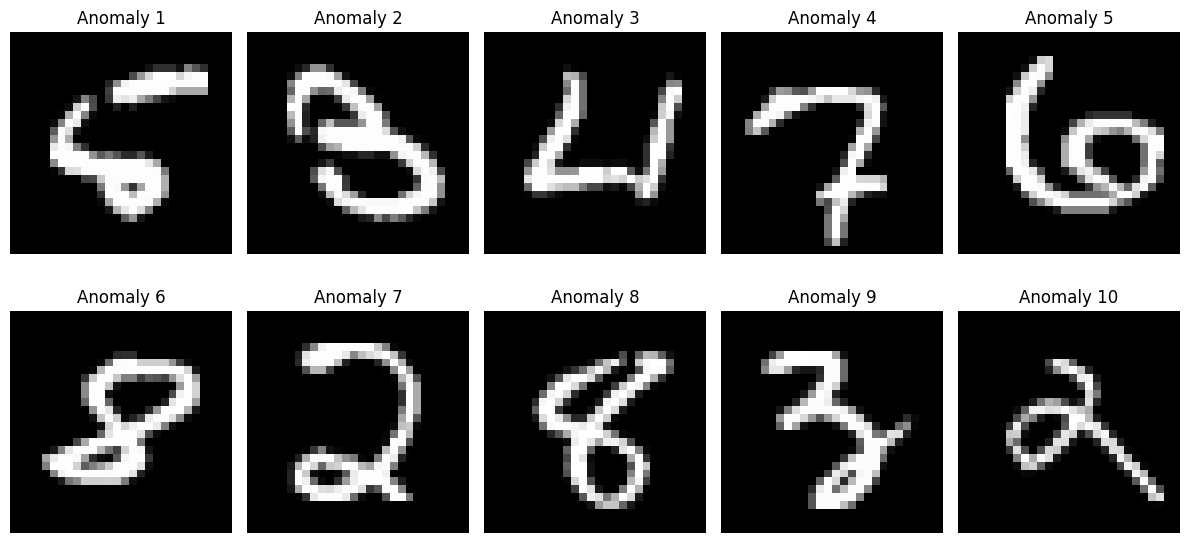

In [16]:
threshold = np.percentile(mse, 95)
y_pred_class = np.where(mse > threshold, 1, 0)

# Display some of the detected anomalies (outliers) and their original digits
anomalous_indices = np.where(y_pred_class == 1)[0][:10]  # Get the indices of the first 10 anomalies
plt.figure(figsize=(12, 6))
for i, idx in enumerate(anomalous_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Anomaly {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## **Isolation Forest Model**

The key idea behind Isolation Forest is to isolate anomalies (outliers) by constructing a tree-based partitioning of the data space. The algorithm is based on the intuition that anomalies are rare instances that can be easily separated from the majority of the data.

In [17]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype('float32') / 255.0
y = mnist.target.astype('int')

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
clf = IsolationForest(contamination=0.05, random_state=42)  # Contamination is the proportion of anomalies expected in the data
clf.fit(X_train)

# Predict anomaly scores for the test set
y_pred = clf.predict(X_test)
y_pred = np.where(y_pred == 1, 0, 1)  # Convert predictions to binary (0: inliers, 1: outliers)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [6]:
# Evaluate the model
n_normal = len(y_test[y_test == 0])
n_anomaly = len(y_test[y_test == 1])
n_detected = len(y_test[y_test == y_pred])
n_correctly_detected = len(y_test[(y_test == 1) & (y_pred == 1)])

print(f"Number of normal instances: {n_normal}")
print(f"Number of anomalies: {n_anomaly}")
print(f"Number of detected instances: {n_detected}")
print(f"Number of correctly detected anomalies: {n_correctly_detected}")

Number of normal instances: 1343
Number of anomalies: 1600
Number of detected instances: 1082
Number of correctly detected anomalies: 0


## **Local Outlier Factor Model**

Local Outlier Factor (LOF) is another popular algorithm for anomaly detection, and it takes a different approach compared to Isolation Forest. LOF is designed to identify local anomalies, meaning instances that are outliers in their local neighborhoods rather than being global anomalies across the entire dataset.

In [9]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
y = mnist.target.astype('int')

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Local Outlier Factor model
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Contamination is the proportion of anomalies expected in the data
y_pred = clf.fit_predict(X_test)

# Convert predictions to binary (0: inliers, 1: outliers)
y_pred = np.where(y_pred == -1, 1, 0)

# Evaluate the model
n_normal = len(y_test[y_test == 0])
n_anomaly = len(y_test[y_test == 1])
n_detected = len(y_test[y_test == y_pred])
n_correctly_detected = len(y_test[(y_test == 1) & (y_pred == 1)])

print(f"Number of normal instances: {n_normal}")
print(f"Number of anomalies: {n_anomaly}")
print(f"Number of detected instances: {n_detected}")
print(f"Number of correctly detected anomalies: {n_correctly_detected}")


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Number of normal instances: 1343
Number of anomalies: 1600
Number of detected instances: 1446
Number of correctly detected anomalies: 122


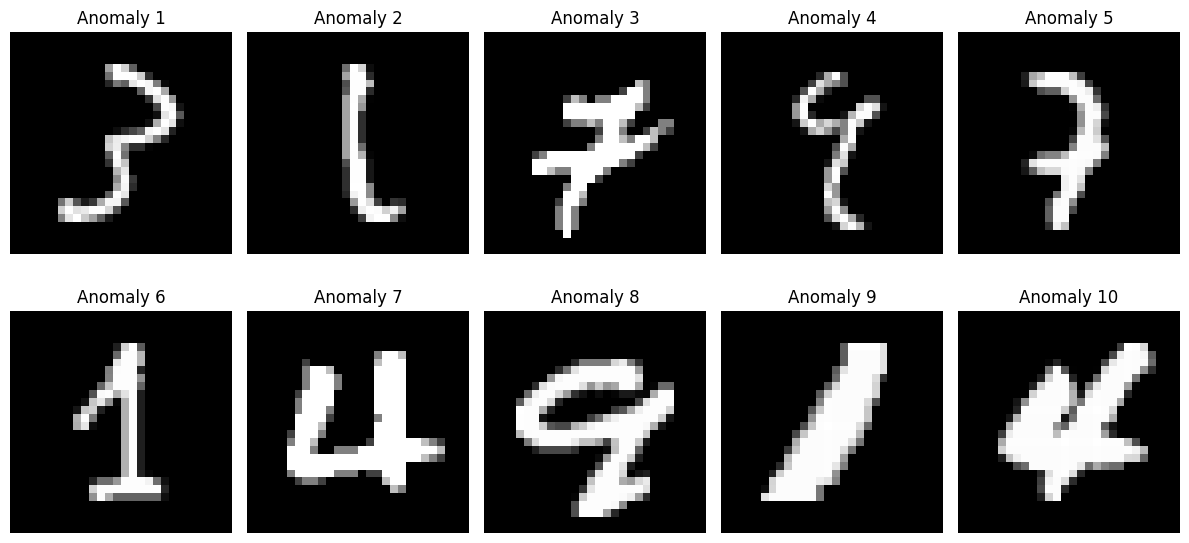

In [13]:
# Plot some of the anomalous digits (outliers) if there are at least 10
anomalous_indices = np.where(y_pred == 1)[0]
n_anomalous_to_plot = min(len(anomalous_indices), 10)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(anomalous_indices[:n_anomalous_to_plot]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test.to_numpy()[idx].reshape(28, 28), cmap='gray')  # Convert X_test to NumPy array and reshape
    plt.title(f"Anomaly {i + 1}")
    plt.axis('off')

plt.tight_layout()
plt.show()